In [2]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq



In [3]:
path = '/content/1661-0.txt'
text = open(path,encoding = 'utf8').read().lower()
print('corpus length :', len(text))

corpus length : 581888


In [5]:
character = sorted(list(set(text)))
char_indicates = dict((c,i) for i, c in enumerate(character))
indices_char = dict((i,c) for i, c in enumerate(character))
print(f'unique chars :{len(character)}')

unique chars :73


In [8]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
  sentences.append(text[i: i+ seq_len])
  next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')


num training examples: 193950


In [11]:
X = np.zeros((len(sentences),seq_len, len(character)), dtype=np.bool_)
y = np.zeros((len(sentences), len(character)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    X[i, t, char_indicates[char]] = 1
  y[i, char_indicates[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

In [12]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [13]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [14]:
X.shape

(193950, 40, 73)

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112841 (440.79 KB)
Trainable params: 112841 (440.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit( X,y,
                    validation_split = 0.01,
                    batch_size=128,
                    epochs=7,
                    shuffle=True ).history

Epoch 1/7
1501/1501 [==============================] - 188s 124ms/step - loss: 1.3749 - accuracy: 0.5799 - val_loss: 1.9292 - val_accuracy: 0.4706
Epoch 2/7
1501/1501 [==============================] - 200s 134ms/step - loss: 1.3583 - accuracy: 0.5837 - val_loss: 1.9491 - val_accuracy: 0.4799
Epoch 3/7
1501/1501 [==============================] - 200s 133ms/step - loss: 1.3472 - accuracy: 0.5866 - val_loss: 1.9430 - val_accuracy: 0.4603
Epoch 4/7
1501/1501 [==============================] - 236s 157ms/step - loss: 1.3366 - accuracy: 0.5895 - val_loss: 1.9322 - val_accuracy: 0.4670
Epoch 5/7
1501/1501 [==============================] - 228s 152ms/step - loss: 1.3283 - accuracy: 0.5912 - val_loss: 1.9331 - val_accuracy: 0.4809
Epoch 6/7
1501/1501 [==============================] - 212s 141ms/step - loss: 1.3198 - accuracy: 0.5935 - val_loss: 1.9458 - val_accuracy: 0.4804
Epoch 7/7
1501/1501 [==============================] - 203s 135ms/step - loss: 1.3137 - accuracy: 0.5957 - val_loss: 1

In [19]:
model.save('NW_keras_model.h5')
pickle.dump(history, open('history.p','wb'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
model = load_model('NW_keras_model.h5')
history = pickle.load(open('history.p','rb'))

In [21]:
loss_and_acc = model.evaluate(X,y)
print('Test Loss', loss_and_acc[0])
print('Test Accuracy', loss_and_acc[1])

6061/6061 [==============================] - 146s 24ms/step - loss: 1.2765 - accuracy: 0.6046
Test Loss 1.2764946222305298
Test Accuracy 0.6046455502510071


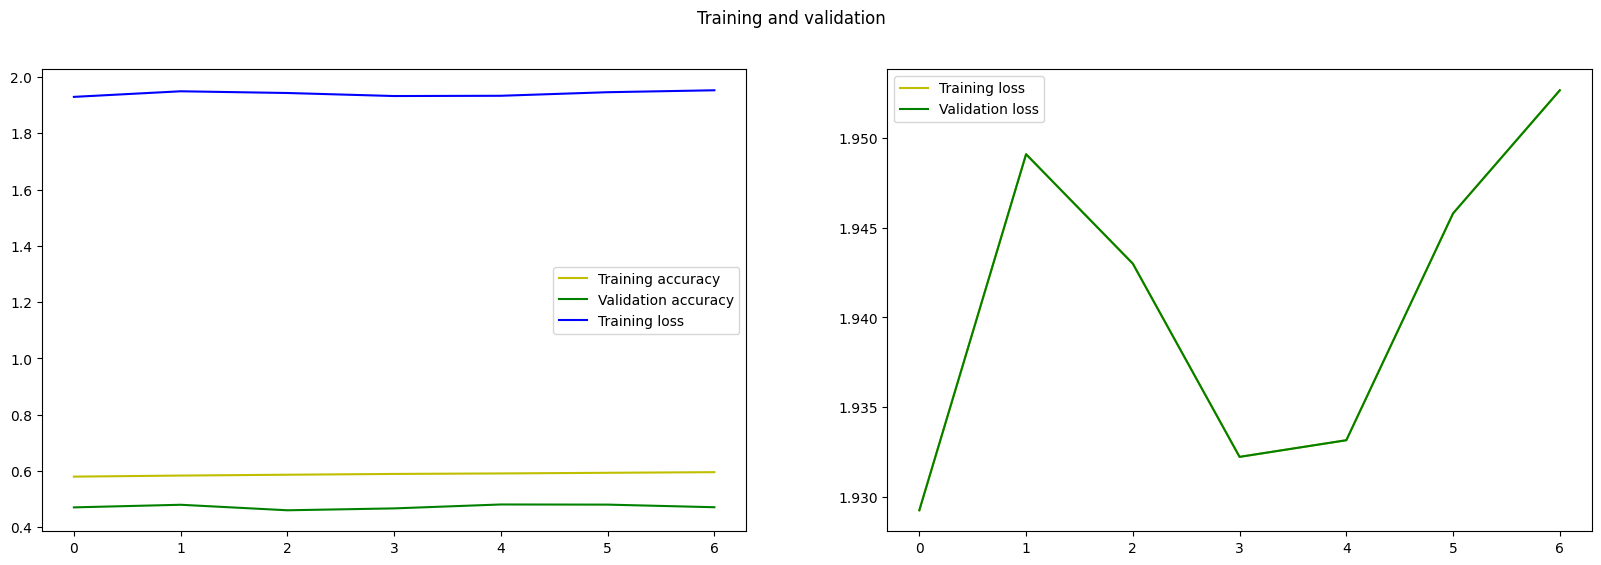

In [36]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['val_loss']
val_loss = history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)

ax[0].plot(epochs, loss, 'b', label='Training loss')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)



plt.suptitle('Training and validation')
plt.show()

In [26]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indicates[char]] = 1
    return x
prepare_input('This is an example of input of our model'.lower())


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [27]:
#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [28]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion


In [29]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [30]:
#Prediction
quotes = [
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "Machine learning  is the study of computer algorithms that improve automatically through experience and by the use of data.",
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.",
    "Thanks for spending your precious time to view my work."

]

In [31]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is subset of machine learn
['ed ', ' to ', 'g ', 'ce ', 'd ']

machine learning  is the study of comput
['e ', 'ce ', 'ting ', 'ured ', 's ']

it is not a lack of love, but a lack of 
['the ', 'a ', 'my ', 'his ', 'its ']

recurrent neural network (rnn) is a type
['wro ', 'ck. ', 'or ', 'stered ', 'rnof ']

thanks for spending your precious time t
['o ', 'hat ', 'rain ', 'ake ', 'ime ']

